In [1]:
import numpy as np
import uproot
import glob
import re
from tqdm import tqdm
import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(20)

In [6]:
'''
file_templates = {
    0.001: '/home/aminali/production/v14_prod/Ap0.001GeV_1e_v3.2.2_v14_tskim/*.root',
    0.01:  '/home/aminali/production/v14_prod/Ap0.01GeV_1e_v3.2.2_v14_tskim/*.root',
    0.1:   '/home/aminali/production/v14_prod/Ap0.1GeV_1e_v3.2.2_v14_tskim/*.root',
    1.0:   '/home/aminali/production/v14_prod/Ap1GeV_1e_v3.2.3_v14_tskim/*.root',
    0:     '/home/aminali/production/v14_prod/v3.2.0_ecalPN_tskim_sizeskim/*.root'
}
'''
file_templates = {
    0.001:  '/home/vamitamas/Samples8GeV/Ap0.001GeV_sim/*.root',
    0.01:  '/home/vamitamas/Samples8GeV/Ap0.01GeV_sim/*.root',
    0.1:   '/home/vamitamas/Samples8GeV/Ap0.1GeV_sim/*.root',
    1.0:   '/home/vamitamas/Samples8GeV/Ap1GeV_sim/*.root',
    0:     '/home/vamitamas/Samples8GeV/v3.3.3_ecalPN*/*.root'
}

data_to_plot = {
    'EcalVeto': {
        'scalars':['xStd_', 'yStd_', 'showerRMS_',
                   'deepestLayerHit_', 'avgLayerHit_',
                   'stdLayerHit_', 'nReadoutHits_',
                   'summedDet_', 'summedTightIso_', 'maxCellDep_'],
        'vectors':[]
    },
    #'HcalVeto': {
        #'scalars': ['passesVeto_'],
        #'vectors': []
    #},
    'HcalRecHits': {
        'scalars': [],
        'vectors': ['id_', 'energy_']
    }
}

In [7]:
def _parse_hid(hid):
    SECTION_MASK = 0x7  # space for up to 7 sections
    SECTION_SHIFT = 18
    LAYER_MASK = 0xFF  # space for up to 255 layers
    LAYER_SHIFT = 10
    STRIP_MASK = 0xFF  # space for 255 strips/layer
    STRIP_SHIFT = 0 

    hcal_section = np.bitwise_and(np.right_shift(hid.astype(np.uint64), SECTION_SHIFT), SECTION_MASK)
    hcal_layer = np.bitwise_and(np.right_shift(hid.astype(np.uint64), LAYER_SHIFT), LAYER_MASK)
    hcal_strip = np.bitwise_and(np.right_shift(hid.astype(np.uint64), STRIP_SHIFT), STRIP_MASK)

    return (hcal_section, hcal_layer, hcal_strip)

def blname(branch, leaf, sig):
    if sig:
        if branch.startswith('EcalVeto') or branch.startswith('HcalVeto'):
            return '{}/{}'.format(f'{branch}_signal', leaf)
        else:
            return '{}/{}.{}'.format(f'{branch}_signal', f'{branch}_signal', leaf)

    else: # bkg (different syntax)
        if branch.startswith('EcalVeto') or branch.startswith('HcalVeto'):
            return '{}/{}'.format(f'{branch}_sim', leaf)
        else:
            return '{}/{}.{}'.format(f'{branch}_sim', f'{branch}_sim', leaf)


In [8]:
plot_vars = {
'xStd_': {},
'yStd_': {},
'showerRMS_': {},
'deepestLayerHit_': {},
'avgLayerHit_': {},
'stdLayerHit_': {},
'nReadoutHits_': {},
'summedDet_': {},
'summedTightIso_': {},
'maxCellDep_': {},
'nHcalHits': {},
'totalHcalEnergy': {},
'totalSideHcalEnergy': {},
'totalBackHcalEnergy': {}
}

nTotal = {}
nPassesVeto = {}
hcalVetoEffs = {}
for mass in file_templates.keys():
    
    print(f"==== m = {mass} ====", flush=True)
    
    sig = True
    if not mass:
        sig = False
    
    branchList = []
    for branchname, leafdict in data_to_plot.items():
        if mass:
            branchname_ = f'{branchname}_signal'
        else:
            branchname_ = f'{branchname}_sim'
        for leaf in leafdict['scalars'] + leafdict['vectors']:
            if branchname == "EcalVeto" or branchname == "HcalVeto":
                branchList.append(branchname_ + '/' + leaf)
            else:
                branchList.append(branchname_ + '/' + branchname_ + '.' + leaf)
    
    nTotal[mass] = 0
    nPassesVeto[mass] = 0
    
    for var in plot_vars.keys():
        plot_vars[var][mass] = []
    
    file_list = glob.glob(file_templates[mass])
    nFiles = len(file_list)
    
    for i, filename in tqdm(enumerate(file_list), total=nFiles):
        if i == 10:
            break
        with uproot.open(filename) as file:
            if not file.keys(): # if no keys in file
                print(f"FOUND ZOMBIE: {filename}  SKIPPING...", flush=True)
                continue
        with uproot.open(filename)['LDMX_Events'] as t:
            if not t.keys(): # if no keys in 'LDMX_Events'
                print(f"FOUND ZOMBIE: {filename}  SKIPPING...", flush=True)
                continue
            key_miss = False
            for branch in branchList:
                if not re.split('/', branch)[0] in t.keys(): # if one or more desired keys missing
                    print(re.split('/', branch)[0])
                    key_miss = True
                    break
            if key_miss:
                print(f"MISSING KEY(S) IN: {filename}  SKIPPING...", flush=True)
                continue
            data = t.arrays(branchList, interpretation_executor=executor)
            
            ecal_vars = {
            # tranverse ecal shower profile variables
            'xStd_': data[blname('EcalVeto', 'xStd_', sig)],
            'yStd_': data[blname('EcalVeto', 'yStd_', sig)],
            'showerRMS_': data[blname('EcalVeto', 'showerRMS_', sig)],
            # longitudinal ecal shower profile variables
            'deepestLayerHit_': data[blname('EcalVeto', 'deepestLayerHit_', sig)],
            'avgLayerHit_': data[blname('EcalVeto', 'avgLayerHit_', sig)],
            'stdLayerHit_': data[blname('EcalVeto', 'stdLayerHit_', sig)],
            # ecal energy profile variables
            'nReadoutHits_': data[blname('EcalVeto', 'nReadoutHits_', sig)],
            'summedDet_': data[blname('EcalVeto', 'summedDet_', sig)],
            'summedTightIso_': data[blname('EcalVeto', 'summedTightIso_', sig)],
            'maxCellDep_': data[blname('EcalVeto', 'maxCellDep_', sig)]
            }
            '''
            hcal_vars = {
            # hcal veto variable
            'passesVeto_': data[blname('HcalVeto', 'passesVeto_', sig)],
            # hcal id and energy
            'hid_': data[blname('HcalRecHits', 'id_', sig)],
            'hcalEnergy_': data[blname('HcalRecHits', 'energy_', sig)]
            }
            '''
            nEvents = len(ecal_vars['nReadoutHits_'])
            nTotal[mass] += nEvents
            
            # fill ecal plot vars
            for i in range(nEvents):
                for var in ecal_vars.keys():
                    plot_vars[var][mass].append(ecal_vars[var][i])
            '''
            hid = hcal_vars['hid_']
            hcalEnergy = hcal_vars['hcalEnergy_']
            
            # fill hcal plot vars
            for i in range(nEvents):
                nHcalHits = sum(hcalEnergy[i] > 0)
                if len(hcalEnergy[i]) == 0:
                    nHcalHits = 0
                plot_vars['nHcalHits'][mass].append(nHcalHits)
                
                totalHcalEnergy = sum(hcalEnergy[i])
                plot_vars['totalHcalEnergy'][mass].append(totalHcalEnergy)
                
                hcal_section, hcal_layer, hcal_strip = _parse_hid(np.array(hid[i]))
                
                totalSideHcalEnergy = 0
                totalBackHcalEnergy = 0
                for j in range(len(hid[i])):
                    if not hcal_section[j] == 0:
                        totalSideHcalEnergy += hcalEnergy[i][j]
                    if hcal_section[j] == 0:
                        totalBackHcalEnergy += hcalEnergy[i][j]
                plot_vars['totalSideHcalEnergy'][mass].append(totalSideHcalEnergy)
                plot_vars['totalBackHcalEnergy'][mass].append(totalBackHcalEnergy)
            
                    
            # hcal veto
            hcal_veto = (hcal_vars['passesVeto_'] == 1)
            nPassesVeto[mass] += len(hcal_vars['passesVeto_'][hcal_veto])
            '''
    # hcal veto efficiency for this mass point
    hcalVetoEffs[mass] = float(nPassesVeto[mass]) / nTotal[mass] if nTotal[mass] else 'no events!'

==== m = 0.001 ====


  4%|███▏                                                                              | 10/260 [00:15<06:18,  1.52s/it]

==== m = 0.01 ====



  5%|███▊                                                                              | 10/216 [00:13<04:44,  1.38s/it]

==== m = 0.1 ====



  4%|███                                                                               | 10/264 [00:14<06:11,  1.46s/it]

==== m = 1.0 ====



  1%|█                                                                                 | 10/743 [00:14<17:50,  1.46s/it]

==== m = 0 ====



  0%|                                                                             | 10/38875 [00:20<22:32:34,  2.09s/it]


In [9]:
%matplotlib notebook

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


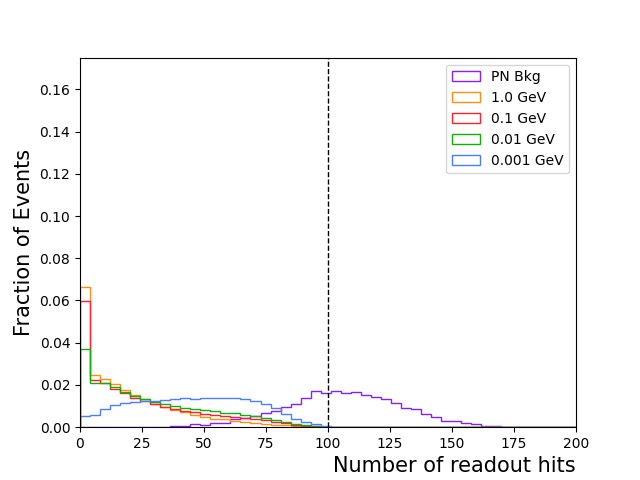

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

colors = ['#4A7DFF', '#14AD0C', '#FF212E', '#FF8F13', '#871EFE'] 
fig, ax = plt.subplots()
var = plot_vars['nReadoutHits_']
vals = [var[mass] for mass in file_templates.keys()]
labels = [f'{mass} GeV' if mass else 'PN Bkg' for mass in file_templates.keys()]
x_max = int(1.1*max(var[mass]))
x_range = (0, x_max)
bins = np.linspace(0, 279, 70)
ax.hist(vals, bins=bins, range=x_range, density=True, stacked=False, histtype='step', color=colors, 
            label=labels, log=False)
ax.legend()
#ax.set_title(f'v14 Number of ECal Readout Hits', fontsize=15)
ax.set_ylabel('Fraction of Events', fontsize = 15)
ax.set_xlabel('Number of readout hits', fontsize=15, ha='right', x=1.0)
ax.set_ylim(0, 0.175)
ax.set_xlim(0, 200)
plt.axvline(100, color='k', linestyle='dashed', linewidth=1)
#plt.savefig("v14_nReadout", facecolor='w', dpi=250)

<IPython.core.display.Javascript object>


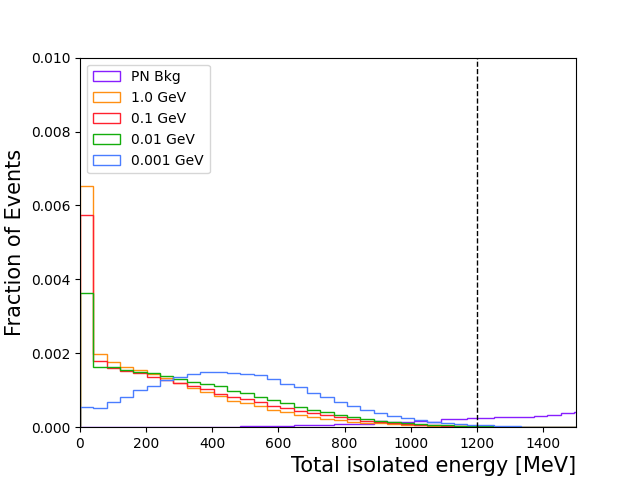

In [31]:
colors = ['#4A7DFF', '#14AD0C', '#FF212E', '#FF8F13', '#871EFE'] 
fig, ax = plt.subplots()
var = plot_vars['summedTightIso_']
vals = [var[mass] for mass in file_templates.keys()]
labels = [f'{mass} GeV' if mass else 'PN Bkg' for mass in file_templates.keys()]
x_max = int(1.1*max(var[mass]))
x_range = (0, x_max)
bins = np.linspace(0, 3999, 100)
ax.hist(vals, bins=bins, range=x_range, density=True, stacked=False, histtype='step', color=colors, 
            label=labels, log=False)
ax.legend()
#ax.set_title(f'v14 Number of ECal Readout Hits', fontsize=15)
ax.set_ylabel('Fraction of Events', fontsize = 15)
ax.set_xlabel('Total isolated energy [MeV]', fontsize=15, ha='right', x=1.0)
ax.set_ylim(0, 0.01)
ax.set_xlim(0, 1500)
plt.axvline(1200, color='k', linestyle='dashed', linewidth=1)
#plt.savefig("v14_isoE", facecolor='w', dpi=250)

<IPython.core.display.Javascript object>


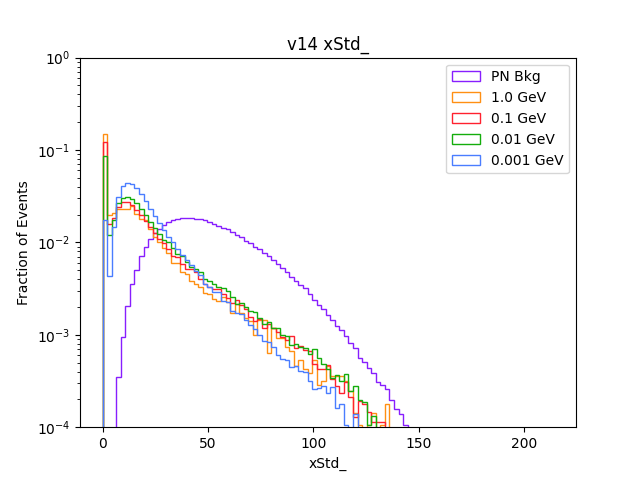

<IPython.core.display.Javascript object>


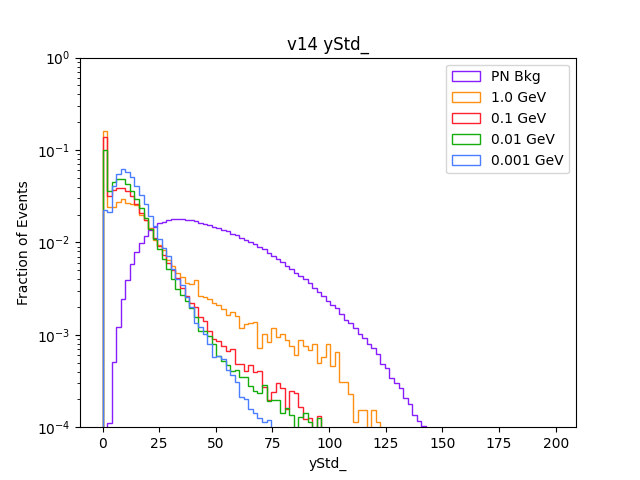

<IPython.core.display.Javascript object>


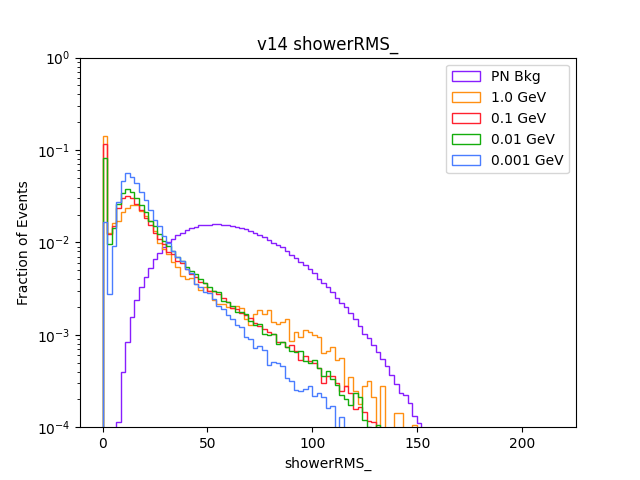

<IPython.core.display.Javascript object>


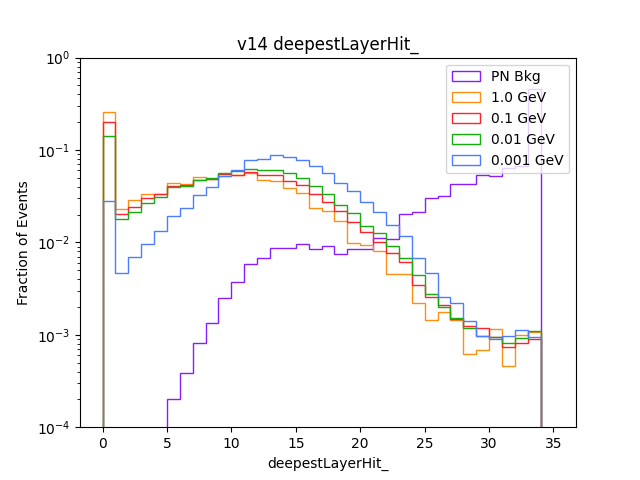

<IPython.core.display.Javascript object>


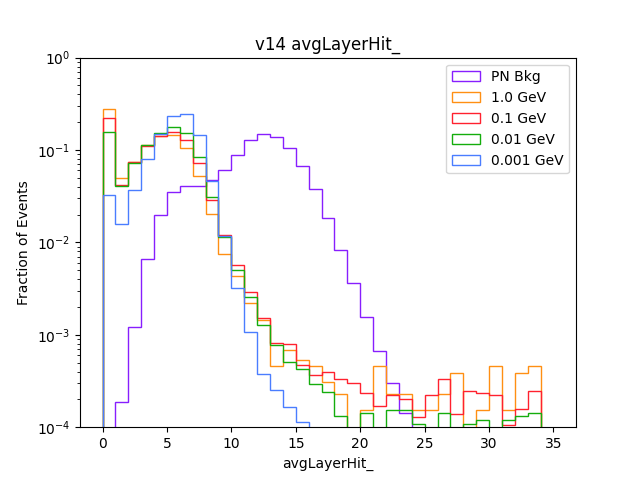

<IPython.core.display.Javascript object>


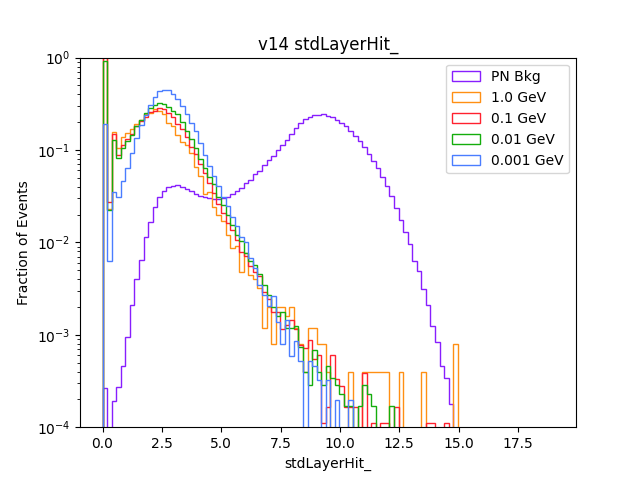

<IPython.core.display.Javascript object>


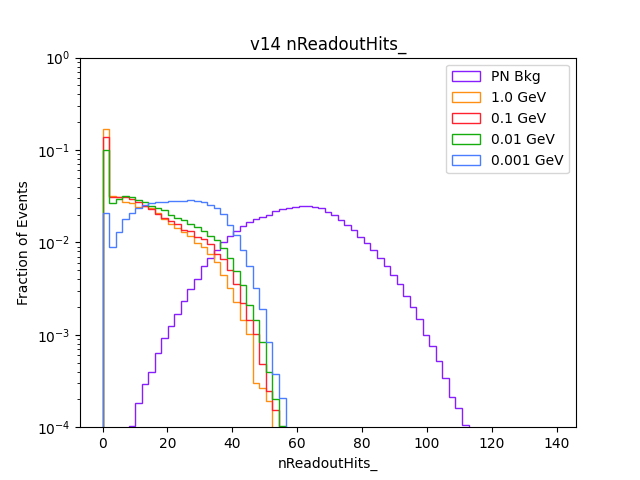

<IPython.core.display.Javascript object>


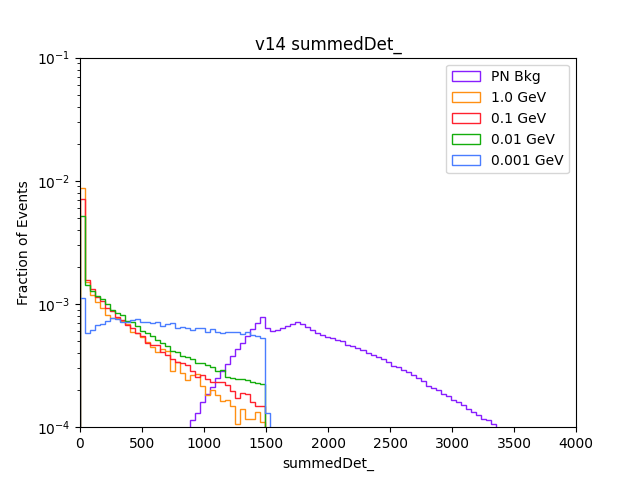

<IPython.core.display.Javascript object>


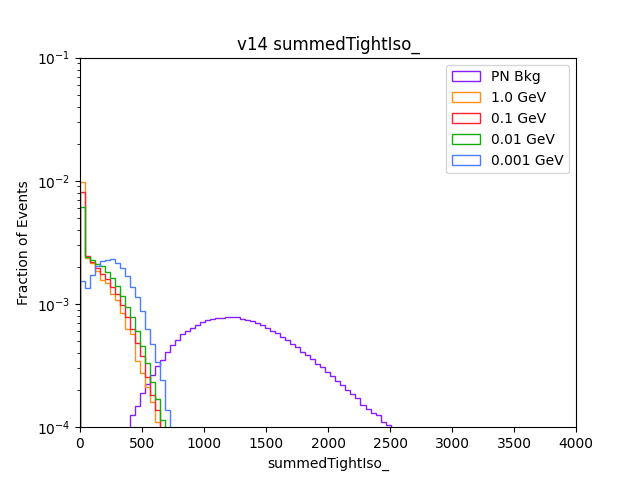

<IPython.core.display.Javascript object>


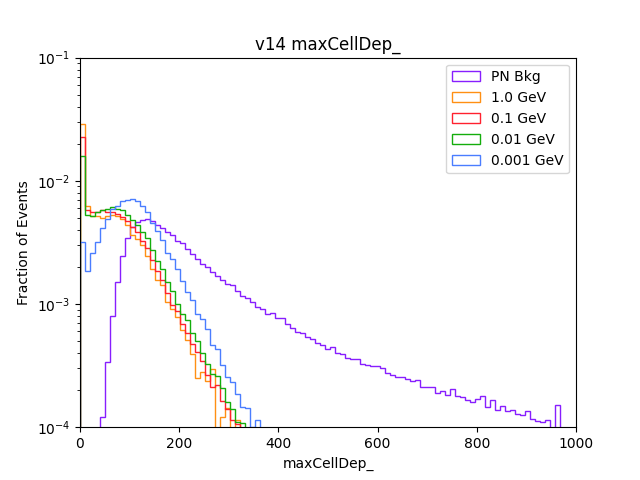

<IPython.core.display.Javascript object>


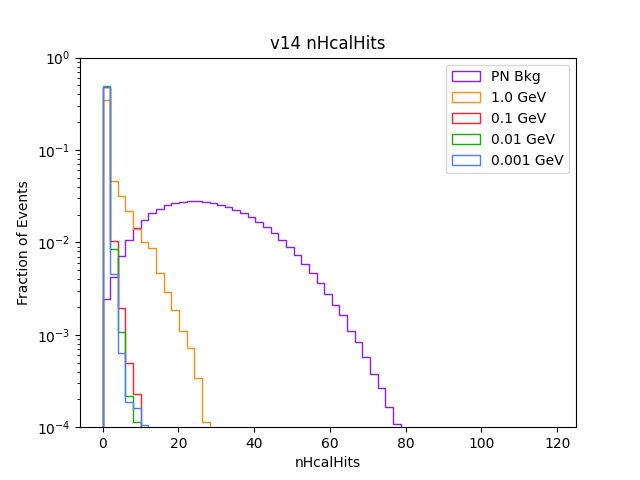

<IPython.core.display.Javascript object>


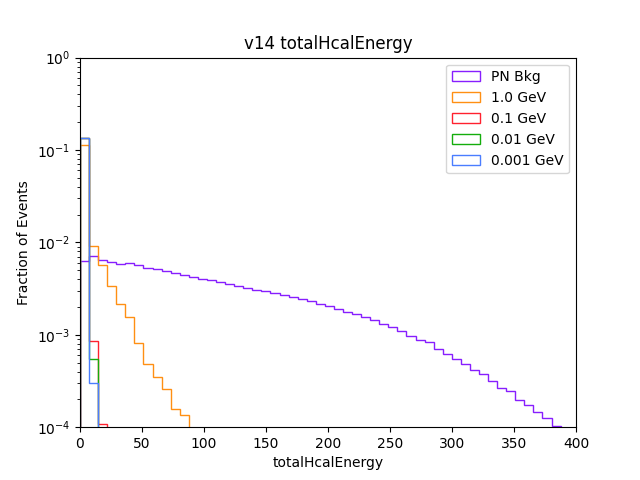

<IPython.core.display.Javascript object>


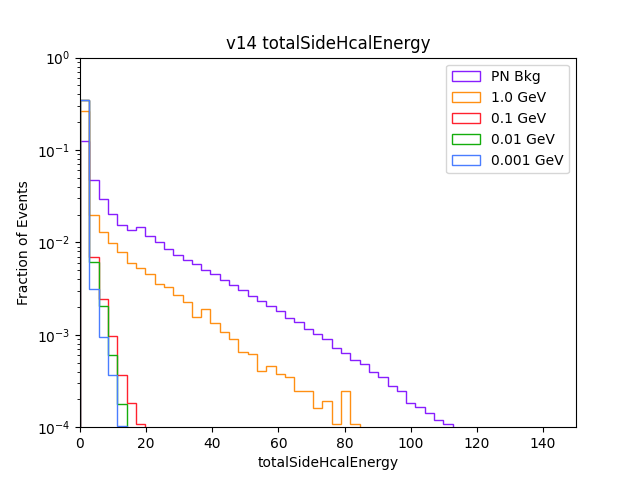

<IPython.core.display.Javascript object>


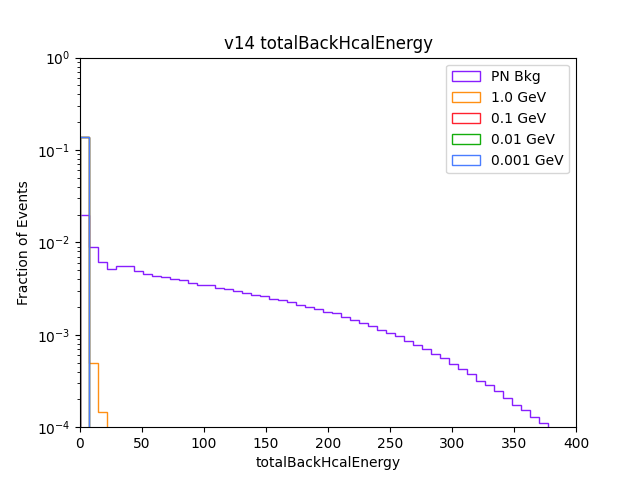

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

colors = ['#4A7DFF', '#14AD0C', '#FF212E', '#FF8F13', '#871EFE'] 
#colors = ['#FF212E', '#FF8F13', '#14AD0C', '#4A7DFF', '#871EFE']
for name, var in plot_vars.items():
    fig, ax = plt.subplots()
    vals = [var[mass] for mass in file_templates.keys()]
    labels = [f'{mass} GeV' if mass else 'PN Bkg' for mass in file_templates.keys()]
    #for mass in file_templates.keys():
        #vals.append(var[mass])
    x_max = int(1.1*max(var[mass]))
    x_range = (0, x_max)
    bins = np.linspace(0,x_range[1]+2,100)
    if name == 'deepestLayerHit_' or name == 'avgLayerHit_':
        bins = np.linspace(0, 35, 36)
    if name == 'nReadoutHits_':
        bins = np.linspace(0, 139, 70)
    if name == 'nHcalHits':
        bins = np.linspace(0, 119, 60)
    if name == 'summedDet_' or name == 'summedTightIso_':
        bins = np.linspace(0, 3999, 100)
    if name == 'maxCellDep_':
        bins = np.linspace(0, 999, 100)
    ax.hist(vals, bins=bins, range=x_range, density=True, stacked=False, histtype='step', color=colors, 
            label=labels, log=True)
    ax.legend()
    ax.set_title(f'v14 {name}')
    ax.set_ylabel('Fraction of Events')
    ax.set_xlabel(f'{name}')
    ax.set_ylim(1e-4, 1)
    if name == 'summedDet_' or name == 'summedTightIso_':
        ax.set_ylim(1e-4, 1e-1)
        ax.set_xlim(0, 4000)
    if name == 'maxCellDep_':
        ax.set_ylim(1e-4, 1e-1)
        ax.set_xlim(0, 1000)
    if name == 'totalHcalEnergy' or name == 'totalBackHcalEnergy':
        ax.set_xlim(0, 400)
    if name == 'totalSideHcalEnergy':
        ax.set_xlim(0, 150)